# Non-linear basis regression

In the previous section we showed how linear regression can be used to make predictions in datasets where the underlying input-output relation is linear. In this section we show how to extend linear regression to model non-linear trends in the data.  

We will use the following dataset, which appears to have been generated by a non-linear underlying function.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

%config InlineBackend.figure_format = 'svg'

In [3]:
x_data = np.load('data/reg_nonlin_x.npy')
y_data = np.load('data/reg_nonlin_y.npy')

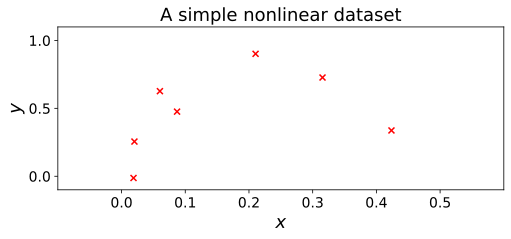

In [4]:
# Plot the data
plt.figure(figsize=(8, 3))
plt.scatter(x_data, y_data, marker = 'x', color = 'red')

# Format plot
plt.title("A simple nonlinear dataset", fontsize=18)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.xlim((-0.1, 0.6)) 
plt.ylim((-0.1, 1.1)) 
plt.xticks(np.linspace(0., 0.5, 6), fontsize=14)
plt.yticks(np.linspace(0., 1., 3), fontsize=14)
plt.show()

In this section we will make use of the insight that we can retain much of the machinery developed earlier by modelling the underlying non-linear function as a linear combination of non-linear basis functions \\(\phi_d(x), d = 0, 1, ..., D\\). 

$$\begin{align}
y_n &= f(x_n) + \epsilon_n && \text{where}~\epsilon_n \sim \mathcal{N}(0, \sigma_{y}^2) \\
f(x_n) &= w_0 + w_1 \phi_{1}(x_n) + w_2 \phi_{2}(x_n) + ... + w_D \phi_{D}(x_n).
\end{align}$$

Suitable choices for the non-linear basis functions might include polynomials $\phi_{d}(x) = x^d$, sinusoids

$$\begin{align}
\phi_{d}(x) = \cos(\omega_d x + \phi_d),
\end{align}$$

or Gaussian bumps

$$ \begin{align}
\phi_d(x) = \exp \left[-\frac{1}{2\sigma^2} (x - \mu_d)^2 \right].
\end{align}$$

Here's an example of a non-linear function constructed from a linear combination of 10 Gaussian bumps.

![](imgs/non-linear-schematic.svg)

## Maximum likelihood fitting

The beauty of this approach to non-linear regression is that **the model is still linear in the parameters** and so fitting proceeds in an analogous manner to the linear case. First, we rewrite the model in terms of a $D+1$ dimensional vector of parameters $\mathbf{w} = [w_0,...,w_{D}]^\top$ and similarly for the basis functions $\boldsymbol{\phi}(x_n) = [1,\phi_1(x_n)...,\phi_{D}(x_n)]^\top$ so that

$$\begin{align}
y_n = w_0 + w_1 \phi_{1}(x_n) + w_2 \phi_{2}(x_n) + ... w_D \phi_{D}(x_n) + \epsilon_n = \boldsymbol{\phi}(x_n)^\top \mathbf{w} + \epsilon_n.
\end{align}$$

Second, we can collect all of the observations and observation noise variables into $N$ dimensional vectors $\mathbf{y} = [y_1,...,y_{N}]^\top$ and $\boldsymbol{\epsilon} = [\epsilon_1,...,\epsilon_{N}]^\top$ giving

$$\begin{align}
\mathbf{y} = \boldsymbol{\Phi}\mathbf{w} + \boldsymbol{\epsilon}.
\end{align}$$

Here \\(\boldsymbol{\Phi}\\) is called the **design matrix** whose entry at the \\(d^{th}\\) row and \\(n^{th}\\) column is \\(\phi_d(x_n)\\),

$$\begin{align}
\boldsymbol{\Phi} =  \begin{pmatrix}
1 & \phi_1(x_1) & \cdots & \phi_D(x_1)\\\
1 & \phi_1(x_2) & \cdots & \phi_D(x_2)\\\
\vdots & \vdots & \ddots & \vdots \\\
1 & \phi_1(x_N) & \cdots & \phi_D(x_N)
\end{pmatrix}.
\end{align}$$


Notice that we have assumed that the $0^{th}$ basis function is $1$ to recover the constant \\(w_0\\) term when multiplied by $\mathbf{w}$. You should convince yourself that this matrix gives the correct linear combination when acting on $\mathbf{w}$. 

We can now proceed either by applying the least squares approach with error:

$$\begin{align}
C_2 = \big|\big| \mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big|\big|^2 = \big(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big)^\top \big(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big),
\end{align}$$

or by minimising the negative log-likelihood:

$$\begin{align}
- \mathcal{L}(\mathbf{w}) = - \text{log}~ p(\mathbf{y}|\boldsymbol{\Phi}, \mathbf{w}, \sigma_y^2) = \frac{N}{2}\text{log}(2\pi \sigma^2) + \frac{1}{2\sigma^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})
\end{align}$$

with respect to $\mathbf{w}$. Again it is easy to convince yourself that the two approaches are equivalent, and that the maximum-likelihood weights are:

$$\begin{align}
\boxed{\mathbf{w} = \big( \boldsymbol{\Phi}^\top\boldsymbol{\Phi}\big)^{-1}\boldsymbol{\Phi}^\top \mathbf{y}}.
\end{align}$$

So, the only change we need to make to our old implementation is to compute the design matrix $\boldsymbol{\Phi}$. Let's fit the model to the toy dataset above using some different choices of basis function. First, we use polynomial basis functions \\(\phi_d(x) = x^d\\) selecting the order $D = 5$.

In [5]:
# Use a fifth order polynomial
D = 5

# Create the design matrix Phi
phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_data])

# Compute the maximum-likelihood w using the Moore-Penrose pseudoinverse
w = np.linalg.solve((phi.T).dot(phi), (phi.T).dot(y_data))

# As with linear regression, the line above is numerically stable version of
# w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_data)

# Report the sum of squared errors to the training data
print(f"Sum squared errors for polynomial of order {D}:"
      f"{np.sum((phi.dot(w) - y_data) ** 2).round(3)}")

Sum squared errors for polynomial of order 5:0.091


We can now plot the mean of the predictive distribution using the maximum likelihood weights, that is

$$\begin{align}
\mathbb{E}[\mathbf{y} | \mathbf{w} = \mathbf{w}_{ML}] = \boldsymbol{\Phi}  \mathbf{w}_{ML}.
\end{align}$$

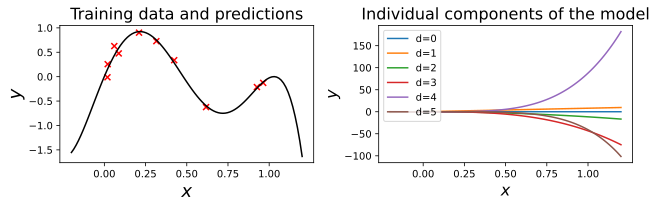

In [6]:
# 100 points equispaced between 0 and 1
x_pred = np.linspace(-0.2, 1.2, 100) 

# Design matrix corresponding to the points above
phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_pred])

# Model predictive means at the points above
y_pred = phi_pred.dot(w)

# Plot training data, predictions and polynomial components
plt.figure(figsize=(9, 3))

# Plot data and model predictions
plt.subplot(1,2,1)
plt.scatter(x_data, y_data, marker = 'x', color = 'red')
plt.plot(x_pred, y_pred, color = 'black')

plt.title("Training data and predictions", fontsize=16)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.xticks(np.linspace(0., 1., 5))
plt.yticks(np.linspace(-1.5, 1., 6))


# Plot each component of the basis separately
plt.subplot(1,2,2)

for d in range(D+1):
    plt.plot(x_pred, w[d] * phi_pred[:, d],label=f"d={d}")

plt.title("Individual components of the model", fontsize=16)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.xticks(np.linspace(0., 1., 5))
plt.yticks(np.linspace(-100, 150, 6))

    
plt.gca().legend(loc="upper left")
plt.tight_layout()
plt.show()

Next we use $D=5$ Gaussian basis functions, 

$$ \begin{align}
\phi_d(x) = \exp \left[-\frac{1}{2\sigma_\phi^2} (x - \mu_d)^2 \right],
\end{align}$$

with centres $\mu_d$ uniformly spaced between 0 and 1, and with widths $\sigma^2_{\phi} = 0.05$.

In [7]:
# Use five Gaussian basis functions
D = 5
var_phi = 0.05

# Create design matrix corresponding to the training data
phi = np.array([[np.exp(-0.5 * (x - d / D) ** 2 / var_phi)
                 for d in range(D)]
                for x in x_data])

# compute the optimal w using the Moore-Penrose pseudoinverse
w = np.linalg.solve((phi.T).dot(phi), (phi.T).dot(y_data))

# Once again, the line above is numerically stable version of
# w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_data)

# Report the sum of squared errors to the training data
print(f"Sum squared errors for polynomial of order {D}:"
      f"{np.sum((phi.dot(w) - y_data) ** 2).round(3)}")

Sum squared errors for polynomial of order 5:0.113


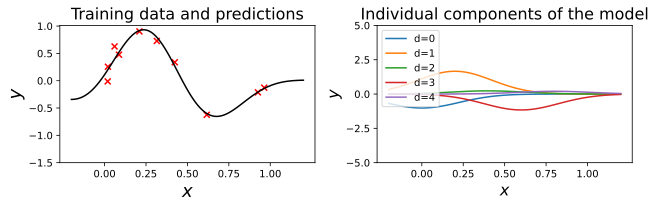

In [8]:
# 100 points equispaced between 0 and 1
x_pred = np.linspace(-0.2, 1.2, 100)

# Create design matrix corresponding to the training data
phi_pred = np.array([[np.exp(-0.5 * (x - d / D) ** 2 / var_phi)
                      for d in range(D)]
                     for x in x_pred])

# Model predictive means at the points above
y_pred = phi_pred.dot(w)

# Plot training data, predictions and polynomial components
plt.figure(figsize=(9, 3))

# Plot data and model predictions
plt.subplot(1,2,1)
plt.scatter(x_data, y_data, marker = 'x', color = 'red')
plt.plot(x_pred, y_pred, color = 'black')

plt.title("Training data and predictions", fontsize=16)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.xticks(np.linspace(0., 1., 5))
plt.yticks(np.linspace(-1.5, 1., 6))


# Plot each component of the basis separately
plt.subplot(1,2,2)

for d in range(D):
    plt.plot(x_pred, w[d] * phi_pred[:, d],label=f"d={d}")

plt.title("Individual components of the model", fontsize=16)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.xticks(np.linspace(0., 1., 5))
plt.yticks(np.linspace(-5, 5, 5))

    
plt.gca().legend(loc="upper left")
plt.tight_layout()
plt.show()

The two models make very similar predictions at the training data with similar training costs $\mathcal{C}_2 \approx 0.1$. The models interpolate very similarly, but extrapolate rather differently (compare the predictions around $x_2 = 1.2$). 

How sensitive are these properties to the hyper parameters? In the code above, **experiment with the model hyperparameters** to see how the fits depend upon:
1. the order of the polynomial (what happens as $D$ gets large?)
2. the number of Gaussian basis functions (what happens as $D$ grows for this model?)
3. the width of the basis functions $\sigma^2_{\phi}$ (explore the effect of narrow and wide basis functions)

By exploring these settings you should be able to find regimes in which the fitted function is overly simple (under-fitting) and where it is overly complex (over-fitting). These concepts are explored in the next section.

## Summary

Linear regression can be converted into non-linear regression by replacing the inputs $\mathbf{x}$ with $D$ basis functions $\phi_d(\mathbf{x})$ (also called features). 

The choice of basis function will effect how the model interpolates and extrapolates. One general approach to extrapolation is to turn it into an interpolation problem in the space defined by the basis functions, by a clever choice of $\phi_d(\mathbf{x})$.

## Questions 

<ol>
<li> <b>Generalisation of basis functions:</b> How do the polynomial and Gaussian basis function models generalise far outside of the region of the data?

<br>
    
<br><details class="graydrop">
<summary>Answer</summary>

<div>
    
The polynomial model extrapolations explode according to the highest order term in the polynomial, $(x) \rightarrow w_D x^D$. The Gaussian basis function model decays away to the constant function $f(x) \rightarrow w_0$ with a length scale related to the width of the basis functions $\approx \sigma_{\phi}$. These are very different behaviours. The extreme extrapolation of polynomials is often inappropriate. Although the extrapolation of the Gaussian model is benign, it limits the extrapolation ability to simple smoothing. 
    
You might like to alter the code to fit sinusoidal basis functions and compare how this class of basis function extropolates.
 
</div>
</details></li>
</ol>

<ol start="2">
<li> Consider a data set whose inputs live in \(\text{dim}(\mathbf{x}) = K\) dimensions. Each input dimension is real valued and bounded, lying in the range \(-L/2 < x_k < L/2\). The inputs are uniformly and densely sampled over the input domain and the outputs are measured. The output function is known to change significantly according to a length-scale \(l\). That is, two function values \(f(\mathbf{x})\) and \(f(\mathbf{x}+\boldsymbol{\delta})\) will typically be very different when \(|\boldsymbol{\delta}|\ge l\). <br> <br>

Estimate how many Gaussian basis functions are required to fit these data. Think about the volume of space you will need to cover with basis functions and what the width and spacing of these functions will have to be.
    
<br><details class="graydrop">
<summary>Answer</summary>
    
The number of basis functions that will be needed scales as
    
$$\begin{align} \mathcal{O}\left(\left(\frac{L}{l}\right)^K\right) \end{align}$$
    
This is a combinatorial number. Fixed basis function models suffer from this _curse of dimensionality_.
    
</details>
<br> </li></ol>

<ol start="3">
<li> In order to side step the curse of dimensionality (see question 2), a machine learner would like to use adaptive basis functions. What's a simple data dependent way of selecting the centres \(\mu_d\) and widths \(\sigma_d^2\) of the Gaussian basis functions? 
    
    
<br>

<br><details class="graydrop">
<summary>Answer</summary>
    
For $\mu_d$ one idea is to place the centres at a randomly selected subset of the data points or to use a clustering algorithm like k-means. For the width, often the median distance between the centres and each data point is used. These simple approaches can mitigate the curse of dimensionality to some extent. A different flavour of approach is to use an infinite number of basis functions as utilised by kernel machines such as Gaussian processes.
    
</details>
<br> </li></ol>

<ol start="4">
<li> Modifiy the code above to fit the data with sinusoidal basis functions, 
    
$$\begin{align} \phi_d(x) = \sin(\omega_d x + \psi_d). \end{align}$$
    
It is sensible to use pairs of sines and cosines ($\psi_d = 0$, $\psi_{d+1} = \pi/2$) with the same frequency? Is there a relationship to Fourier transforms?
<br> </li></ol>
